In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from pickle import load as pload
from json import load as load_json

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src

In [2]:
INPUT_VARIABLES = ['Tac', 'hs', 'u', 'Rg']
OUTPUT_VARIABLES = ['An', 'E', 'Rg', 'Tleaf']
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']

In [3]:
EXPERIMENT_ROOT = '/media/mcndt/thesis/thesis-cyborg-plants/results/gdc_can1_6days_3runs/'
# EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/gdc_can1_6days_3runs'

## Creating utility classes for handling experiment data

In [4]:
from src.model.reservoir_state import ReservoirState
from src.model.hydroshoot_experiment import HydroShootExperiment

## Loading all the experiment data

In [5]:
# Source: personal python snippet library
def get_dirs_in_directory(path):
    """get all subdirectories in the given path (non-recursive)."""
    dirs = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        dirs.extend([f for f in dirnames])
        break  # only explore top level directory
    return dirs

In [6]:
# Loading all the data
runs = []

run_dirs = get_dirs_in_directory(EXPERIMENT_ROOT)
for d in run_dirs:
  run_path = os.path.join(EXPERIMENT_ROOT, d)
  run = HydroShootExperiment(run_path)
  runs.append(run)

print(runs)

[HydroShootExperiment(n_steps=144, state_size=360), HydroShootExperiment(n_steps=144, state_size=360), HydroShootExperiment(n_steps=144, state_size=360)]


## Training a cross-validated, regularized readout function

In [7]:
TARGET = 'An'      # Absorbed shortwave irradiance by whole plant
STATE_VAR = 'Tlc'  # Leaf temperature

STATE_SIZE = 32
SAMPLES_PER_RUN = 8
WARMUP_STEPS = 24  # ignore the first N steps as a model warmup

DEFAULT_REGULIZATION = 1.0

### Prepare dataset for training

In [8]:
# def get_target(run, target):
#     if target in run.get_input_variables():
#         return run.inputs[target].to_numpy()
#     elif target in run.get_output_variables():
#         return run.outputs[target].to_numpy()
#     else:
#         raise KeyError(f"No target of name '{target}'")

# def reshape(X):
#     """Reshapes a training set of shape (samples, *dims) 
#     into a single, concatenated series of shape (*dims)."""
#     n_samples = X.shape[0]
#     dims = X.shape[1:]
#     _X = X.reshape(n_samples * dims[0], *dims[1:])

#     for i in range(n_samples):
#         old_values = X[i]
#         new_values = _X[i * dims[0]:(i + 1) * dims[0]]
#         assert(np.allclose(old_values, new_values))

#     return _X

In [9]:
runs[0].get_target('Tleaf').shape

(144,)

In [15]:
def prepare_data(runs, state_var, target, state_size=32, samples_per_run=1, warmup_steps=0):
  """Returns (X, y, groups) for the given state variable and target.
  
  state_size (int): the amount of leaves to randomly sample. Default is 32.
  samples_per_run (int): The amount of samples to draw from the total state. Samples will not overlap. Default is 1.
  warmup_steps (int): The amount of time steps to discard as simulation warmup time. Default is 0.

  Assumes that every run has the same state size.
  """
  if runs[0].state_size() < state_size * samples_per_run:
    raise ValueError(f'Cannot draw {samples_per_run} samples of size {state_size} from an experiment of total state size {runs[0].state_size()}.')

  _X = []
  _y = []
  _groups = []

  for i_group, run in enumerate(runs):
    state_samples = np.random.choice(run.state_size(), size=(samples_per_run, state_size), replace=False)
    state_data = run.states[STATE_VAR]
    for i_sample in range(samples_per_run):
      row_idx = state_samples[i_sample,:]
      X_i = state_data[WARMUP_STEPS:, row_idx]
      y_i = run.get_target(target)[WARMUP_STEPS:]
      g_i = np.ones(len(X_i)) * i_group
      # # add time data to readout
      # t = np.arange(run.n_steps()).reshape((run.n_steps(), 1))
      # time_signal = np.sin(t / 24 * np.pi * 2)[WARMUP_STEPS:]
      # X_i = np.concatenate((X_i, time_signal), axis=1)
      _X.append(X_i)
      _y.append(y_i)
      _groups.append(g_i)

  # Concatenate all series for use in sklearn
  X = np.concatenate(_X, axis=0)
  y = np.concatenate(_y, axis=0)
  groups = np.concatenate(_groups, axis=0)
  
  return X, y, groups

In [16]:
X, y, groups = prepare_data(runs, STATE_VAR, TARGET, 
    state_size=STATE_SIZE, 
    samples_per_run=SAMPLES_PER_RUN, 
    warmup_steps=WARMUP_STEPS)

print('Shapes:', X.shape, y.shape, groups.shape)


Shapes: (2880, 32) (2880,) (2880,)


### Creating training-validation folds

In [17]:
from sklearn.model_selection import GroupKFold

folds = GroupKFold(n_splits=3)

### Defining the loss function

In [18]:
from src.learning.scorers import nmse_scorer

### Determining the model score

In [19]:
from util import print_cv_scores, print_search_scores, print_search_best_params

In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

readout = Pipeline([
    ('rescale', StandardScaler()),
    # ('pca', PCA(n_components=STATE_SIZE // 8)),
    ('ridge_regression', Ridge(alpha=DEFAULT_REGULIZATION))
])

cv_scores = cross_validate(readout, X, y, 
    groups=groups, 
    cv=folds, 
    scoring=nmse_scorer, 
    return_train_score=True, 
    n_jobs=-1, 
    verbose=False)

print('--- Untuned score ---')
print_cv_scores(cv_scores)

--- Untuned score ---

+-------- FIT STATISTICS --------+
	Training score =         -0.6333 +/- 0.00993
	Cross-validation score = -0.8387 +/- 0.01382


In [21]:
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 500)

}]

grid_search = GridSearchCV(readout, 
  param_grid=search_grid, 
  cv=folds, 
  scoring=nmse_scorer, 
  n_jobs=-1, 
  verbose=False, 
  return_train_score=True
  )

grid_search.fit(X, y, groups=groups)

print('\n\n--- Tuned hyperparemeters ---')
print_search_best_params(grid_search)
print_search_scores(grid_search)



--- Tuned hyperparemeters ---

+----- OPTIMAL HYPERPARAMS ------+
	ridge_regression__alpha = 941.7766006869518

+-------- FIT STATISTICS --------+
	Training score =         -0.6994 +/- 0.01004
	Cross-validation score = -0.7131 +/- 0.02023


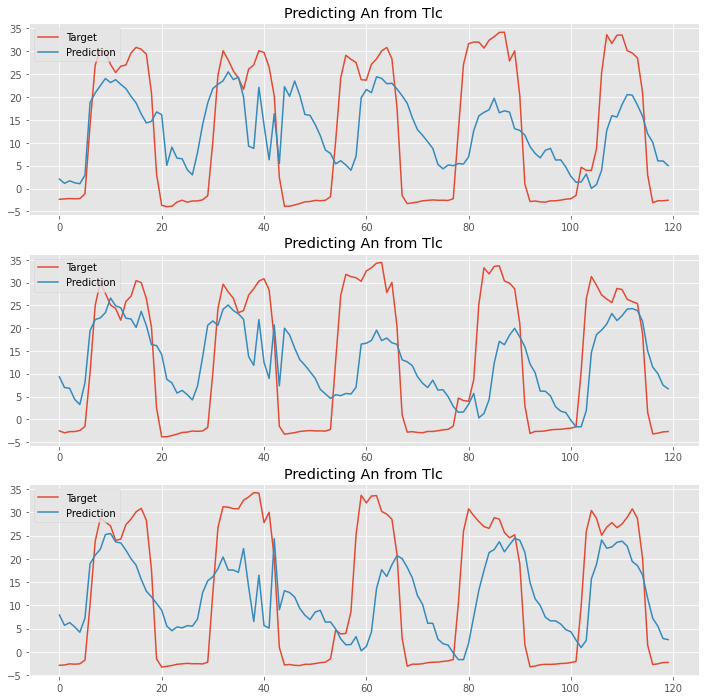

In [23]:
# visualize fit

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(3, 1, figsize=(12, 12))

  for i, run in enumerate(runs):
    state_idx = np.random.choice(run.state_size(), STATE_SIZE, replace=False)
    X = run.states[STATE_VAR][WARMUP_STEPS:, state_idx]


    # # add time data to readout
    # t = np.arange(run.n_steps()).reshape((run.n_steps(), 1))
    # time_signal = np.sin(t / 24 * np.pi * 2)[WARMUP_STEPS:]
    # X = np.concatenate((X, time_signal), axis=1)



    target = run.outputs[TARGET][WARMUP_STEPS:].to_numpy()
    y_pred = grid_search.predict(X)

    ax[i].plot(target, label='Target')
    ax[i].plot(y_pred, label='Prediction')
    ax[i].set_title(f'Predicting {TARGET} from {STATE_VAR}')
    ax[i].legend()

  plt.show()